# One Step
Performing one step between *before* and *after* texts

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import clustering
import classification
import merge
import split
from text_preprocess import sentence_preprocess, SentBERT

In [4]:
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

## Load data

We will address the 1-step process between each of the 3 *before*-*after* pairs:
* Large diff, Short text (**LS**) $~~~~~~~~~~~~~~~~~~~$ (2015-03-08 -> 2015-09-08)
* Large diff, Long text (**LL**) $~~~~~~~~~~~~~~~~~~~~$ (2020-04-21 -> 2020-10-24)
* Small diff, Medium-length text (**SM**) $~~~$ (2018-03-18 -> 2018-09-19)

In [5]:
data = pd.read_csv('BlackLivesMatter_revisions.csv')
step = 'SM'

if step == 'LS':
    data = data[data.date.isin(['2015-03-08', '2015-09-08'])]
elif step == 'LL':
    data = data[data.date.isin(['2020-04-21', '2020-10-24'])]
elif step == 'SM':
    data = data[data.date.isin(['2018-03-18', '2018-09-19'])]

data.index = ['before', 'after']
data

,date,text
before,2018-03-18,\nBlack Lives Matter (BLM) is an international...
after,2018-09-19,\nBlack Lives Matter (BLM) is an international...


## Preprocess

In [6]:
data['sentences'], data['clean_sentences'] = zip(*data['text'].map(sentence_preprocess))
data

,date,text,sentences,clean_sentences
before,2018-03-18,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...
after,2018-09-19,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...


### Sentence embeddings

In [7]:
bert_model = SentBERT()
data['embeddings'] = data['clean_sentences'].apply(bert_model.embed)
data

,date,text,sentences,clean_sentences,embeddings
before,2018-03-18,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...,"[[0.0020600236, 0.029929025, -0.13784839, 0.01..."
after,2018-09-19,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...,"[[0.0020600236, 0.029929025, -0.13784839, 0.01..."


In [8]:
data.loc['before', 'embeddings'].shape

(363, 384)

Embeddings dimension is 384. It might be too large to work with.<br>
* For clustering and prediction purposes, we will project the embeddings into 10 dimensions using UMAP.<br>
* For visualization purposes, we will project the embeddings into 2 dimensions using UMAP.

In [10]:
from text_preprocess import Umap
d = 30
n = data.loc['before', 'embeddings'].shape[0]
umap_d = Umap(n_components=d, n_init_observations=n)
umap_2 = Umap(n_components=2, n_init_observations=n)

umap_d.fit(data.loc['before', 'embeddings'])
data['d_embeddings'] = [umap_d.transform(data.loc['before', 'embeddings']),
                          umap_d.transform(data.loc['after', 'embeddings'])]

umap_2.fit(data.loc['before', 'embeddings'])
data['2_embeddings'] = [umap_2.transform(data.loc['before', 'embeddings']),
                         umap_2.transform(data.loc['after', 'embeddings'])]

data

,date,text,sentences,clean_sentences,embeddings,d_embeddings,2_embeddings
before,2018-03-18,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...,"[[0.0020600236, 0.029929025, -0.13784839, 0.01...","[[10.704534, 5.481211, 6.2049108, 6.2082267, 4...","[[8.581037, 6.2238035], [12.781168, 8.441933],..."
after,2018-09-19,\nBlack Lives Matter (BLM) is an international...,[\nBlack Lives Matter (BLM) is an internationa...,[black lives matter blm international activist...,"[[0.0020600236, 0.029929025, -0.13784839, 0.01...","[[10.832233, 5.5617447, 6.170548, 6.223216, 4....","[[8.65535, 6.090802], [12.978143, 8.4509325], ..."


In [11]:
data.loc['before', '2_embeddings'].shape

(363, 2)

## Clustering on before once

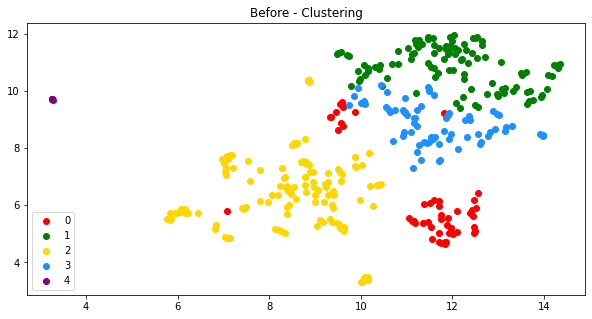

In [12]:
from matplotlib.colors import ListedColormap
cmap = np.array(['red', 'green', 'gold', 'dodgerblue', 'purple', 'brown', 'black', 'grey', 'blue', 'lightgreen', 'pink', 'cyan'])

clusterer = clustering.KMeansClustering(k=5)
clusterer.fit(data.loc['before', 'd_embeddings'])
before_labels = clusterer.get_labels()

plt.figure(figsize=(10, 5))
for label in np.unique(before_labels):
    plt.scatter(*data.loc['before', '2_embeddings'][before_labels == label].T, c=cmap[label], label=label)
plt.legend()
plt.title('Before - Clustering')
plt.show()

In [13]:
from collections import Counter
clusters_size_before = Counter(before_labels)

In [14]:
from text_preprocess import word_cloud, common_words

before_common = common_words(data.loc['before', 'clean_sentences'], before_labels, k=15)
before_common

{0: {'clinton': 0.16616141314526833,
  'presidential': 0.16201268412229952,
  'debate': 0.13071081343505947,
  'malley': 0.1244187964321127,
  'hillary': 0.1244187964321127,
  'republican': 0.1244187964321127,
  'obama': 0.11377924377067244,
  'candidate': 0.11377924377067244,
  'trump': 0.10739387822194443,
  'president': 0.10038030155698219,
  'could': 0.1000624747151641,
  'aclu': 0.1000624747151641,
  'dnc': 0.1000624747151641,
  'bernie': 0.1000624747151641,
  'reform': 0.09179637746180333},
 1: {'officer': 0.1099872966441725,
  'shot': 0.10206850447399014,
  'texas': 0.10050858127227959,
  'charged': 0.10050858127227959,
  'carolina': 0.09524926739382897,
  'arrested': 0.09090759376445244,
  'rouge': 0.08902881935518457,
  'rallied': 0.08902881935518457,
  'baton': 0.08902881935518457,
  'november': 0.08902881935518457,
  'killed': 0.08476530136536722,
  'incident': 0.08141560624688884,
  'francisco': 0.08141560624688884,
  'minnesota': 0.08141560624688884,
  '000': 0.08141560624

In [15]:
COLORS = ['\033[91m', '\033[96m', '\033[93m', '\033[94m', '\033[95m']
END_COLOR = '\033[0m'

for i, c in enumerate(COLORS):
    print(f'{c}cluster {i}')

for i, (sent, label) in enumerate(zip(data.loc['before', 'sentences'], before_labels)):
    c = COLORS[label]
    print(f'{c}{sent}{END_COLOR}')
    if i == 20:
        break

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4

Black Lives Matter (BLM) is an international activist movement, originating in the African-American community, that campaigns against violence and systemic racism towards black people.
BLM regularly holds protests speaking out against police killings of black people, and broader issues such as racial profiling, police brutality, and racial inequality in the United States criminal justice system.
[1]
In 2013, the movement began with the use of the hashtag #BlackLivesMatter on social media after the acquittal of George Zimmerman in the shooting death of African-American teen Trayvon Martin the preceding February.
Black Lives Matter became nationally recognized for its street demonstrations following the 2014 deaths of two African Americans: Michael Brown, resulting in protests and unrest in Ferguson, and Eric Garner in New York City.
[2][3] Since the Ferguson protests, participants in the movement have demonstrated against the deaths of 

## Classify new datapoints based on old clusters

Note that *after* text includes not only new data points, but exactly the entire dataset after this iteration.<br>
In other words, *before* data points are no longer exsist, and should be deleted.

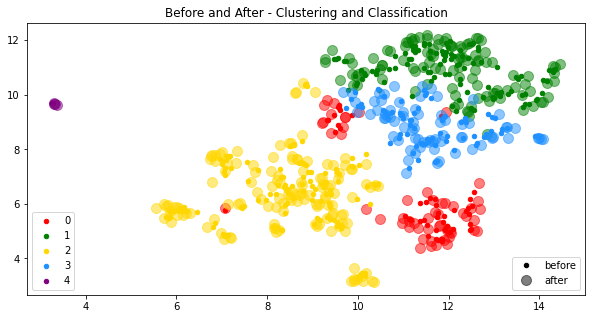

In [16]:
classifier = classification.SVMClassifier()
classifier.fit(data.loc['before', 'd_embeddings'], before_labels)
after_labels = classifier.predict(data.loc['after', 'd_embeddings'])

plt.figure(figsize=(10, 5))
for label in np.unique(before_labels):
    scatter1 = plt.scatter(*data.loc['before', '2_embeddings'][before_labels == label].T, c=cmap[label], label=label, s=20)
    scatter2 = plt.scatter(*data.loc['after', '2_embeddings'][after_labels == label].T, c=cmap[label], s=100, alpha=0.5)

legend1 = plt.legend()
plt.gca().add_artist(legend1)
plt.legend([scatter1.legend_elements(prop='sizes')[0][0], scatter2.legend_elements(prop='sizes')[0][0]],
           ['before', 'after'], loc='lower right')
plt.title('Before and After - Clustering and Classification')
plt.show()

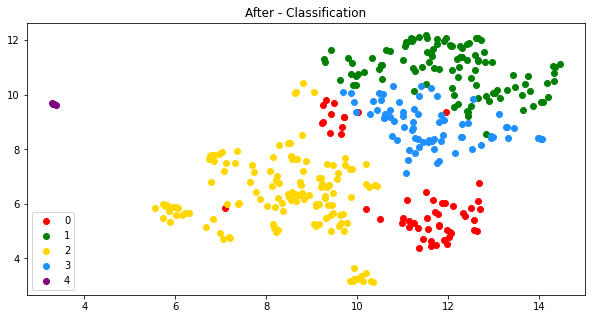

In [17]:
plt.figure(figsize=(10, 5))
for label in np.unique(before_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][after_labels == label].T, c=cmap[label], label=label)
plt.legend()
plt.title('After - Classification')
plt.show()

In [18]:
after_common = common_words(data.loc['after', 'clean_sentences'], after_labels, k=15)

Before, topic=1:


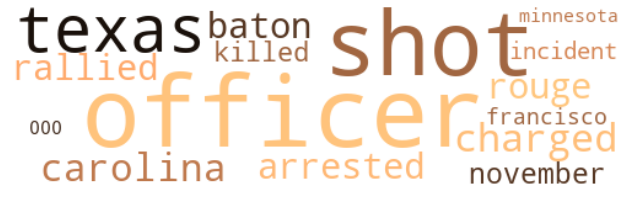

After, topic=1:


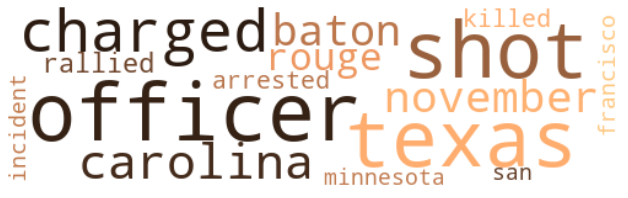

In [19]:
topic = 1
print(f'Before, topic={topic}:')
word_cloud(before_common[topic])
print(f'After, topic={topic}:')
word_cloud(after_common[topic])

Before, topic=3:


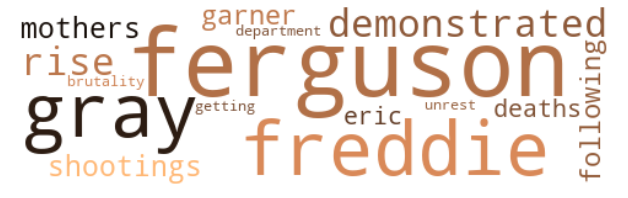

After, topic=3:


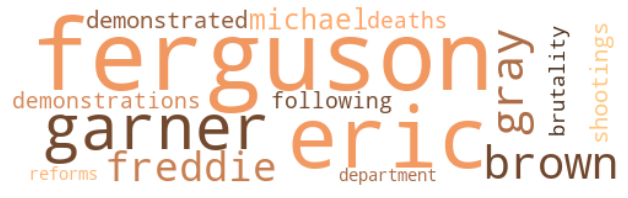

In [20]:
topic = 3
print(f'Before, topic={topic}:')
word_cloud(before_common[topic])
print(f'After, topic={topic}:')
word_cloud(after_common[topic])

In [ ]:
"""a try for topic labeling - maybe come back to this later (this one is not successful)"""
pass
# from text_preprocess import topic_labeling
# from gensim.downloader import load as gensim_load

# glove_model = gensim_load('glove-wiki-gigaword-50')
# before_common_5 = common_words(data.loc['before', 'clean_sentences'], before_labels, k=5)
# topic_labeling(before_common_5, glove_model)

## Merge Clusters
So far we only predicted new points labels by original clusters. But what if it is more likley *after* that there will be less clusters than before?

In [21]:
merger = merge.NearestCentroidVolume()
after_merge_labels, merges = merger.fit_transform(data.loc['after', 'd_embeddings'], after_labels)
print(merges)

{}


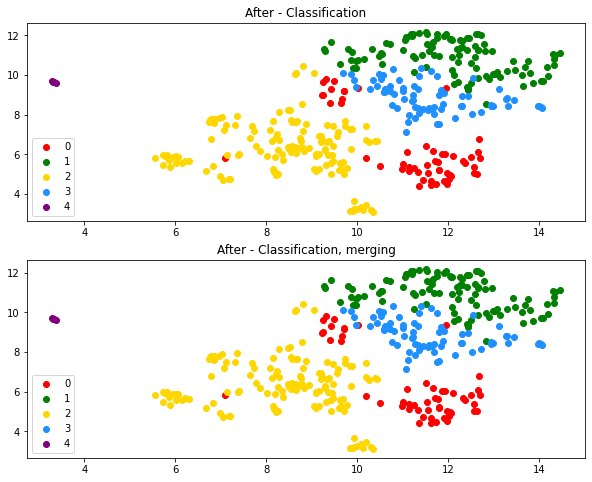

In [31]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)

for label in np.unique(after_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][after_labels == label].T, c=cmap[label], label=label)
plt.legend()
plt.title('After - Classification')


plt.subplot(2,1,2)
for label in np.unique(after_merge_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][after_merge_labels == label].T, c=cmap[label], label=label)
plt.title('After - Classification, merging')
plt.legend()
plt.show()

In [24]:
if len(merges) > 0:
    first_merge = list(merges.items())[0]
    topic = first_merge[1][0]
    before_common = common_words(data.loc['before', 'clean_sentences'], before_labels, k=15)
    print(f'Before, topic={topic}:')
    word_cloud(before_common[topic])

    topic = first_merge[1][1]
    before_common = common_words(data.loc['before', 'clean_sentences'], before_labels, k=15)
    print(f'Before, topic={topic}:')
    word_cloud(before_common[topic])

    topic = first_merge[0]
    after_common = common_words(data.loc['after', 'clean_sentences'], after_merge_labels, k=15)
    print(f'After (merging), topic={topic}:')
    word_cloud(after_common[topic])

## Split Clusters
We handled the scenario where it is more likley *after* that there will be less clusters than before.<br>
We will also handle the opposite scenario, where it it likely that a cluster should be splitted.

In [27]:
np.unique(after_merge_labels)

array([0, 1, 2, 3, 4])

In [28]:
splitter = split.KMeansVolume()
after_split_labels, splits = splitter.fit_transform(data.loc['after', 'd_embeddings'], after_merge_labels)
print(splits)

3 optional splits (by volume criterion), only {0: (5, 6)} splits performed.
{0: (5, 6)}


Before, topic=0:


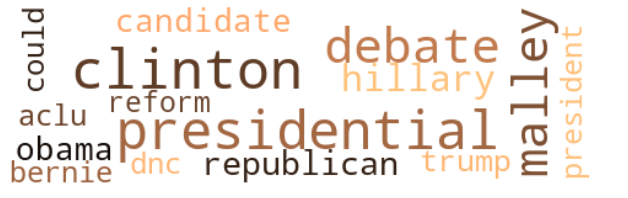

After (splitting), topic=5:


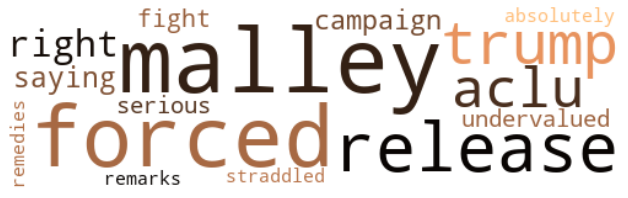

After (splitting), topic=6:


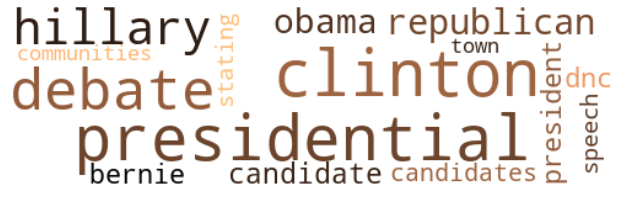

In [29]:
if len(splits) > 0:
    first_split = list(splits.items())[0]
    topic = first_split[0]
    before_common = common_words(data.loc['before', 'clean_sentences'], before_labels, k=15)
    print(f'Before, topic={topic}:')
    word_cloud(before_common[topic])

    topic = first_split[1][0]
    after_common = common_words(data.loc['after', 'clean_sentences'], after_split_labels, k=15)
    print(f'After (splitting), topic={topic}:')
    word_cloud(after_common[topic])
    
    topic = first_split[1][1]
    after_common = common_words(data.loc['after', 'clean_sentences'], after_split_labels, k=15)
    print(f'After (splitting), topic={topic}:')
    word_cloud(after_common[topic])

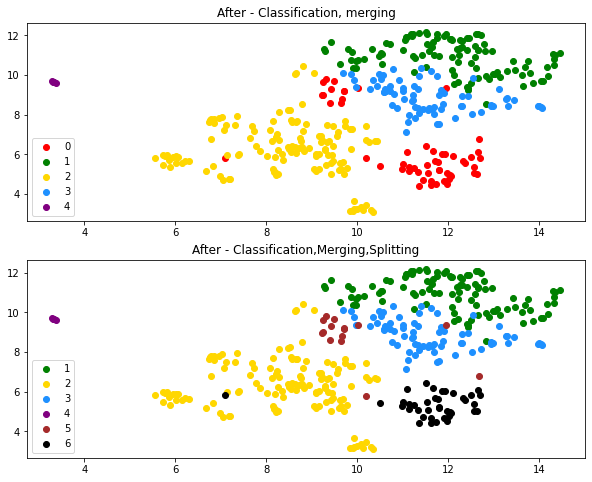

In [32]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)

for label in np.unique(after_merge_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][after_merge_labels == label].T, c=cmap[label], label=label)
plt.title('After - Classification, merging')
plt.legend()


plt.subplot(2,1,2)
for label in np.unique(after_split_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][after_split_labels == label].T, c=cmap[label], label=label)
plt.legend()
plt.title('After - Classification,Merging,Splitting')
plt.show()

In [33]:
clusters_size_after = Counter(after_split_labels)

If we would like to see how a clustering would look like directly on this data (we will use number of clusters achieved after splitting):

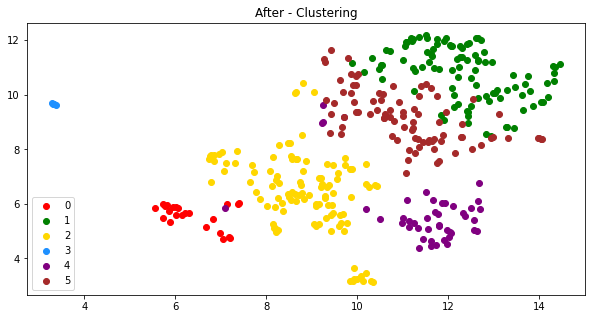

In [35]:
new_k = len(np.unique(after_split_labels))

clusterer = clustering.KMeansClustering(k=new_k)
clusterer.fit(data.loc['after', 'd_embeddings'])
clustering_after_labels = clusterer.get_labels()

plt.figure(figsize=(10, 5))
for label in np.unique(clustering_after_labels):
    plt.scatter(*data.loc['after', '2_embeddings'][clustering_after_labels == label].T, c=cmap[label], label=label)
plt.legend()
plt.title('After - Clustering')
plt.show()

In [36]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from([(i, {'t': 0, 's': clusters_size_before[i]}) for i in range(5)])

for m in merges.items():
    G.add_nodes_from([(m[0], {'t': 1, 's': clusters_size_after[m[0]]})])
    G.add_edge(m[1][0], m[0])
    G.add_edge(m[1][1], m[0])

for s in splits.items():
    G.add_nodes_from([(s[1][0], {'t': 1, 's': clusters_size_after[s[1][0]]})])
    G.add_nodes_from([(s[1][1], {'t': 1, 's': clusters_size_after[s[1][1]]})])
    G.add_edge(s[0], s[1][0])
    G.add_edge(s[0], s[1][1])

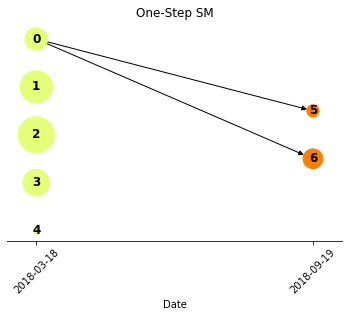

In [37]:
# get attributes for plotting
nodes_size = np.array(list(nx.get_node_attributes(G, 's').values())) * 10
nodes_color = list(nx.get_node_attributes(G, 't').values())
pos = nx.multipartite_layout(G, 't')

# plot
fig, ax = plt.subplots()
nx.draw(G, with_labels=True, font_weight='bold', pos=pos, node_size=nodes_size,
        node_color=nodes_color, cmap='Wistia', ax=ax)

# add x-axis with date ticks
limits=plt.axis('on') # turns on axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=True, labelbottom=True)
xticks = sorted(np.unique(np.array(list(pos.values())).T[0]))
ax.set_xticks(ticks=xticks, labels=data['date'].values, rotation=45)
ax.set_xlabel('Date')

ax.set_title(f'One-Step {step}')
plt.show()